# Santé et population
### Imports

In [213]:
import pandas as pd
import numpy as np
import xlrd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

### Creation des dictionnaires associant spécialités et départements dans les différents documents

In [214]:
# Dictionnaire des Specialitées
key_specialite = pd.read_excel('KEY.xls', sheet_name="Specialite")
key_specialite = key_specialite.set_index('Specialite_1')['Specialite_2'].to_dict()

# Dictionnaire des Départements
key_departement = pd.read_excel('KEY.xls',sheet_name="Departement")
key_departement = key_departement.set_index('Departement_1')['Departement_2'].to_dict()

### Conversion des dictionnaires en DataFrames

In [215]:
# Honoraires DF
df_nomenclature = pd.read_excel('Honoraires_2016.xls', sheet_name="Nomenclature des PS", header=None, skiprows=3).drop(2, axis=1)
df_nomenclature = df_nomenclature.set_index(1)[0].to_dict()

# Import all honoraires dataFrame
df_honoraires = {}
sheetnames = xlrd.open_workbook(r'Honoraires_2016.xls', on_demand=True).sheet_names()
for sheet in sheetnames:
    df_honoraires[sheet]=pd.read_excel('Honoraires_2016.xls', sheet_name=sheet)

### Import des densités de médecins par spécialité et département

In [216]:
# Import density
df_densite = pd.read_excel('Densite_2016.xls', skiprows=4).set_index("SPECIALITE")

### Création du DataFrame global regroupant toutes les informations

In [217]:
 colnames = ["Specialite", "Departement", "Effectifs", "Densite", "Honoraires_sans_depassement", "Depassement", "Frais_deplacement", "Total"]
df = pd.DataFrame(columns=colnames)
i = 0
for key_s, value_s in key_specialite.items():
    for key_d, value_d in key_departement.items():
        density = df_densite[key_s][key_d]
        specialite = key_s
        departement = value_d
        effectifs = df_honoraires[df_nomenclature[value_s]][(df_honoraires[df_nomenclature[value_s]][df_nomenclature[value_s]] == value_s) & (df_honoraires[df_nomenclature[value_s]]['DEPARTEMENT'] == value_d)].iloc[0]['EFFECTIFS']
        honoraires = df_honoraires[df_nomenclature[value_s]][(df_honoraires[df_nomenclature[value_s]][df_nomenclature[value_s]] == value_s) & (df_honoraires[df_nomenclature[value_s]]['DEPARTEMENT'] == value_d)].iloc[0]['HONORAIRES SANS DEPASSEMENT (Euros)']
        depassement = df_honoraires[df_nomenclature[value_s]][(df_honoraires[df_nomenclature[value_s]][df_nomenclature[value_s]] == value_s) & (df_honoraires[df_nomenclature[value_s]]['DEPARTEMENT'] == value_d)].iloc[0]['DEPASSEMENTS (Euros)']
        deplacement = df_honoraires[df_nomenclature[value_s]][(df_honoraires[df_nomenclature[value_s]][df_nomenclature[value_s]] == value_s) & (df_honoraires[df_nomenclature[value_s]]['DEPARTEMENT'] == value_d)].iloc[0]['FRAIS DE DEPLACEMENT (Euros)']
        total = df_honoraires[df_nomenclature[value_s]][(df_honoraires[df_nomenclature[value_s]][df_nomenclature[value_s]] == value_s) & (df_honoraires[df_nomenclature[value_s]]['DEPARTEMENT'] == value_d)].iloc[0]['TOTAL DES HONORAIRES (Euros)']
        df.loc[i] = [specialite, departement, effectifs, density, honoraires, depassement, deplacement, total]
        i += 1

### Cleaning du DataFrame

In [259]:
# Data cleaning
df['Specialite'] = df['Specialite'].str.replace('È', 'e').str.replace('À', 'a').str.lower()
df = df[df['Depassement'] != "nc"]
df_clean = df.set_index(['Specialite', 'Departement'])
df_clean['Ratio'] = np.where(df_clean['Total'] != 0, df_clean['Depassement']/(df_clean['Total']+1), 0)

### Creation d'un premier plot pour observer les résultats dans le cas des médecins généralistes

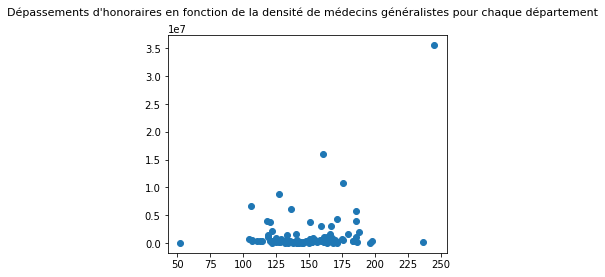

In [232]:
# Single plot to observe results
fig = plt.figure(figsize=(5,4))
fig.suptitle("Dépassements d'honoraires en fonction de la densité de médecins généralistes pour chaque département", fontsize = 11)

plt.plot(df_clean.loc['medecine generale']['Densite'], df_clean.loc['medecine generale']['Depassement'], "o")
plt.show()

### Création de plots pour chaque profession

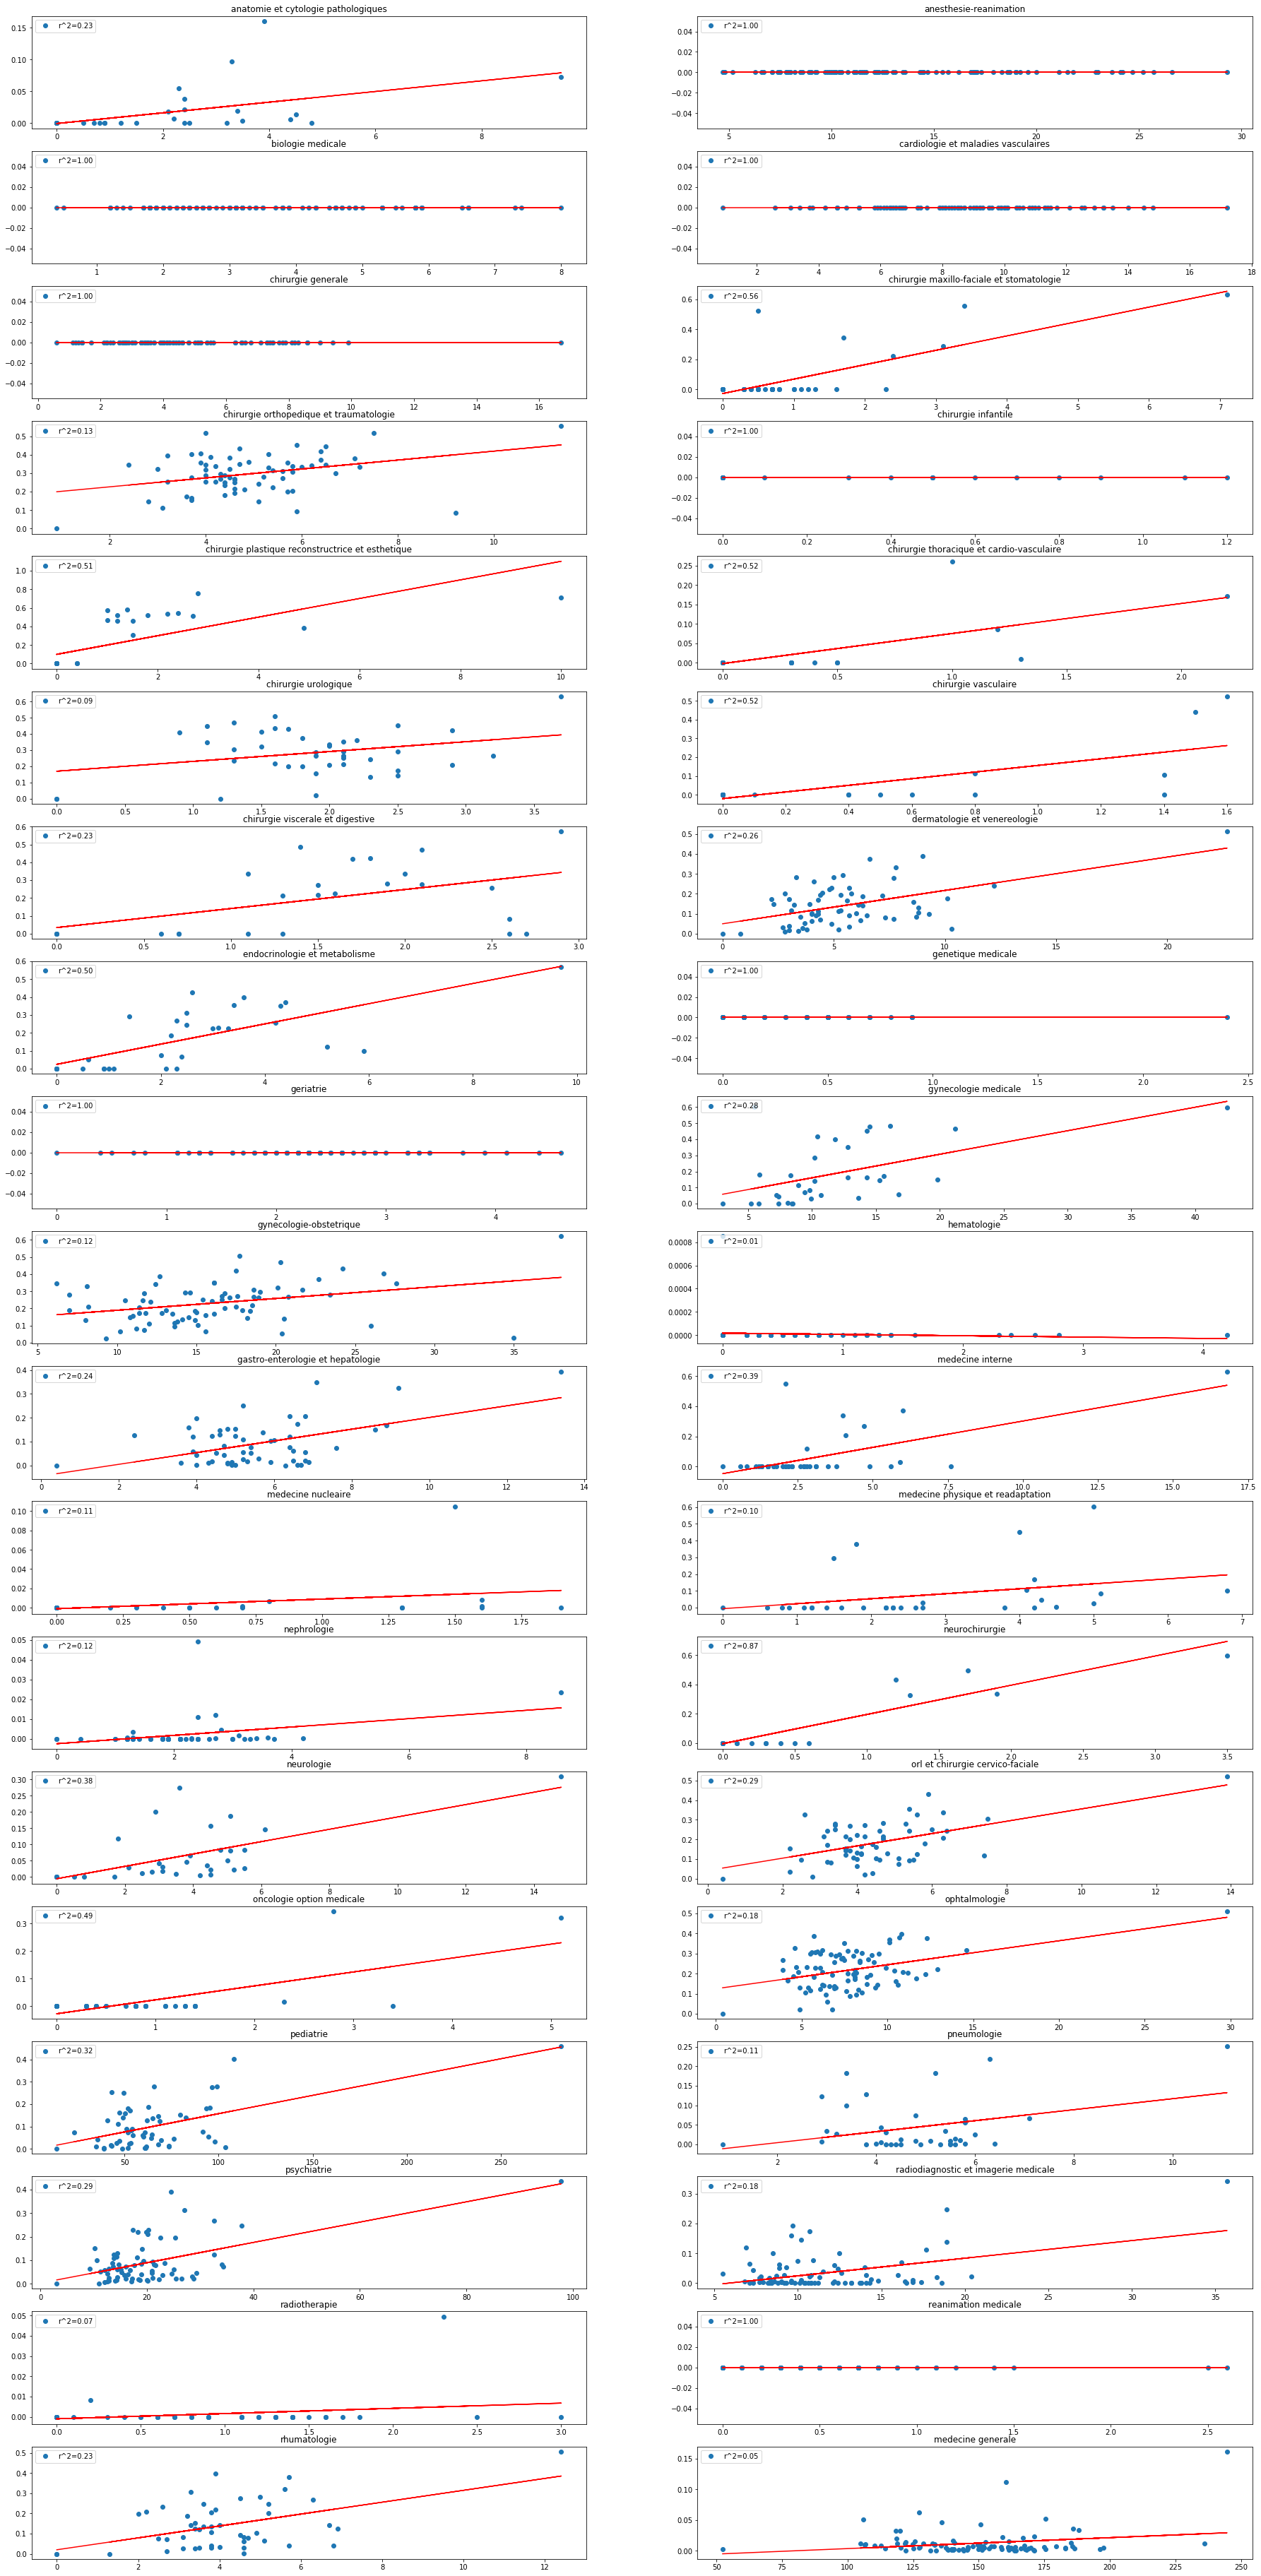

In [224]:
x = pd.DataFrame.from_dict(key_specialite, orient = 'index')
specialite_list = pd.Series(x.index.tolist()).str.replace('È', 'e').str.replace('À', 'a').str.lower()

ncols = 2
nrows = int(np.ceil(len(key_specialite) / (1.0*ncols)))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 500))
plt.subplots_adjust(left=0.2, bottom=0.4, right=1, top=0.5, wspace=0.2, hspace=0.2)
counter = 0


for i in range(nrows):
    for j in range(ncols):
        ax = axes[i][j]
        if counter < len(key_specialite):
            lr = LinearRegression().fit(df_clean.loc[specialite_list[counter]][['Densite']], df_clean.loc[specialite_list[counter]][['Ratio']])     
            # Prediction
            pred = lr.predict(df_clean.loc[specialite_list[counter]][['Densite']])
            # Plot scatter & regression
            ax.plot(df_clean.loc[specialite_list[counter]]['Densite'],df_clean.loc[specialite_list[counter]]['Ratio'],'o', label='r^2={:.2f}'.format(lr.score(df_clean.loc[specialite_list[counter]][['Densite']],df_clean.loc[specialite_list[counter]][['Ratio']])))         
            ax.plot(df_clean.loc[specialite_list[counter]]['Densite'],pred,c='red')
            ax.set_title(specialite_list[counter])
            leg = ax.legend(loc='upper left')
        else:
            ax.set_axis_off()

        counter += 1
plt.show()

### Creation du DataFrame global indexé par département

In [225]:
df_clean_2 = df.set_index(['Departement', 'Specialite'])
df_clean_2 = df_clean_2.sort_values(by = 'Departement')
df_clean_2['Ratio'] = np.where(df_clean_2['Total'] != 0, df_clean_2['Depassement']/(df_clean_2['Total']+1), 0)


### Création de plots pour chaque département

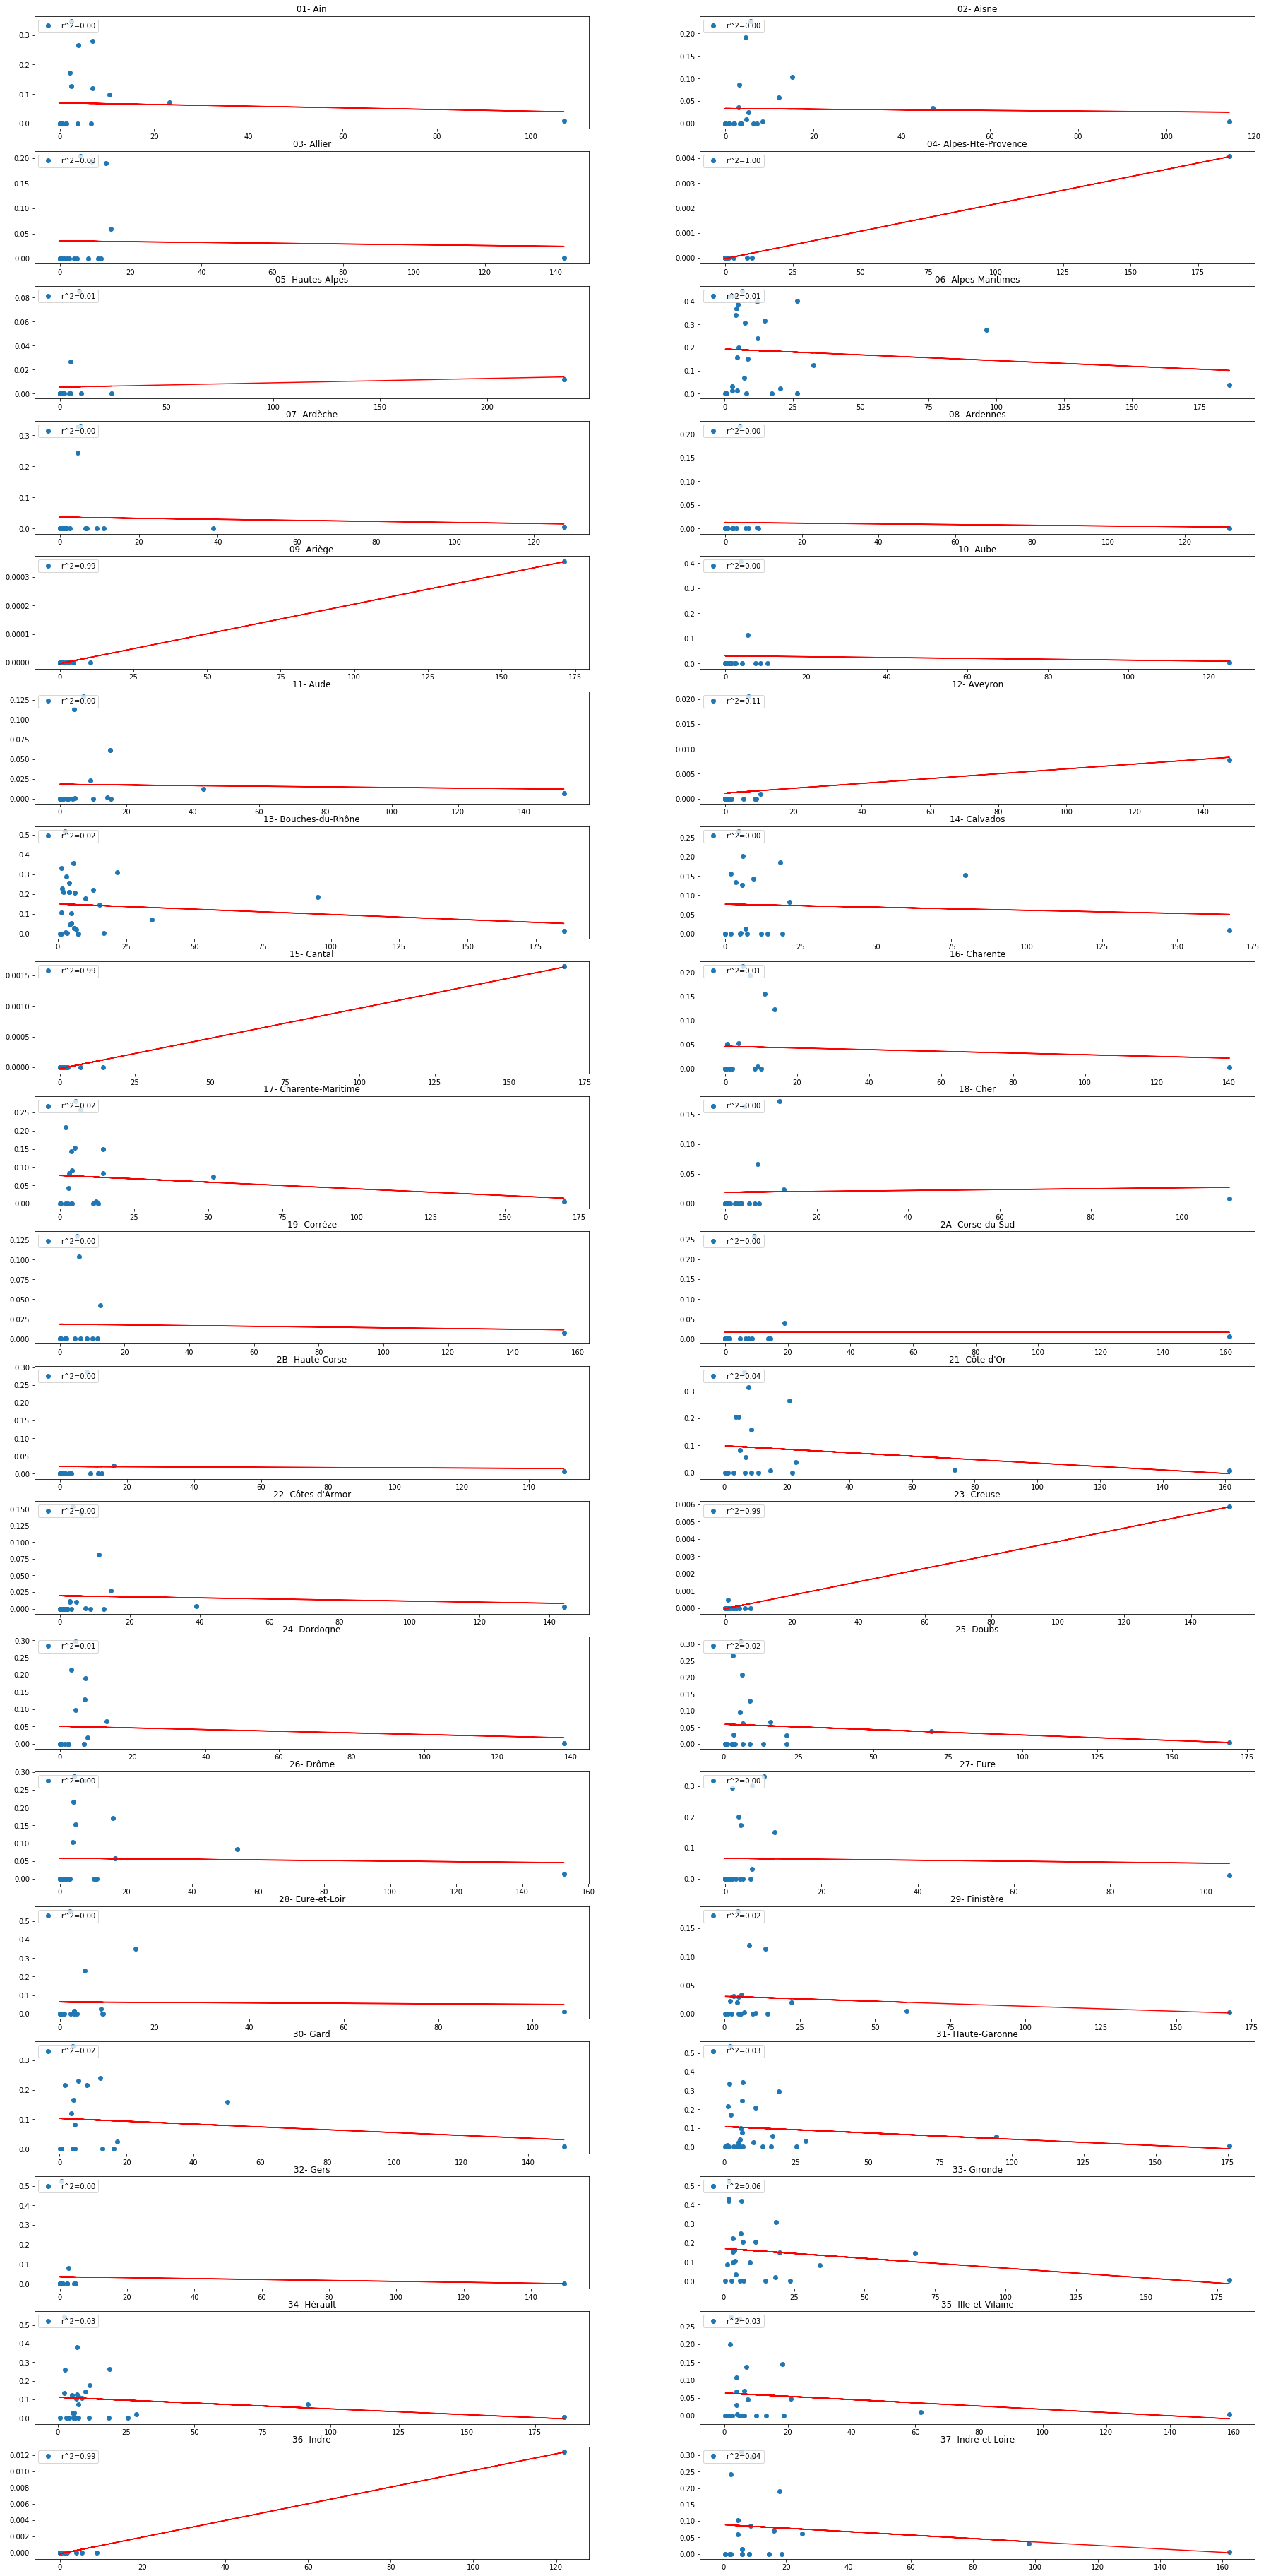

In [226]:
df_departements = pd.DataFrame.from_dict(key_departement, orient = 'index')
departement_list = pd.Series(df_departements[0].tolist())

ncols = 2
nrows = int(np.ceil(len(key_specialite) / (1.0*ncols)))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 500))
plt.subplots_adjust(left=0.2, bottom=0.4, right=1, top=0.5, wspace=0.2, hspace=0.2)
counter = 0

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i][j]
        if counter < len(key_departement):
            lr = LinearRegression().fit(df_clean_2.loc[departement_list[counter]][['Densite']], df_clean_2.loc[departement_list[counter]][['Ratio']])
            # Prediction
            pred = lr.predict(df_clean_2.loc[departement_list[counter]][['Densite']])
            # Plot scatter & regression
            ax.plot(df_clean_2.loc[departement_list[counter]]['Densite'],df_clean_2.loc[departement_list[counter]]['Ratio'],'o',label='r^2={:.2f}'.format(lr.score(df_clean_2.loc[departement_list[counter]][['Densite']],df_clean_2.loc[departement_list[counter]][['Ratio']])))         
            ax.plot(df_clean_2.loc[departement_list[counter]]['Densite'],pred,c='red')
            ax.set_title(departement_list[counter])
            leg = ax.legend(loc='upper left')
        else:
            ax.set_axis_off()

        counter += 1
plt.show()

### Creation du DataFrame contenant les informations sur la démographie de la population

In [265]:
df_population = pd.read_excel('estim-pop.xls',sheet_name="2016", skiprows = 4).set_index('Departement')

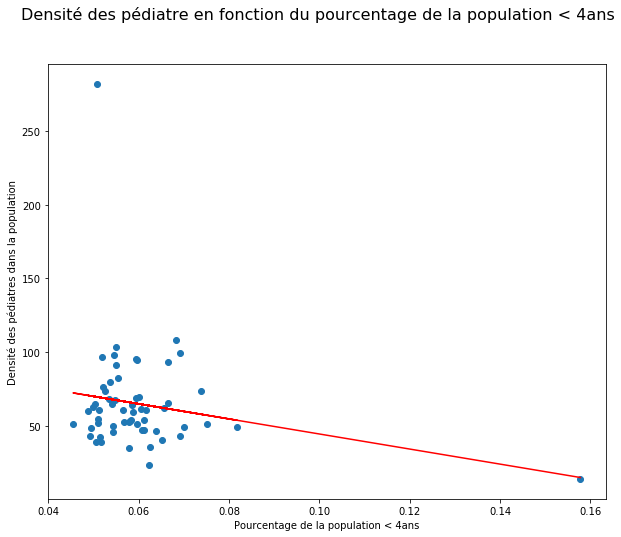

In [267]:
index_departement_pediatrie = list(df_clean.loc['pediatrie'].index)
df_pediatrie = pd.concat([df_clean.loc['pediatrie'], df_population.loc[index_departement_pediatrie]], axis=1)
df_pediatrie['Ratio 0 à 4 ans'] = df_pediatrie['0 à 4 ans'] / df_pediatrie['Total Population']

# Regression lineaire
lr = LinearRegression().fit(df_pediatrie[['Ratio 0 à 4 ans']],df_pediatrie['Densite'])

# Prediction
pred = lr.predict(df_pediatrie[['Ratio 0 à 4 ans']])

# Graphique nuage de point & regression
fig = plt.figure(figsize=(10, 8))
fig.suptitle('Densité des pédiatre en fonction du pourcentage de la population < 4ans', fontsize = 16)
plt.plot(df_pediatrie['Ratio 0 à 4 ans'],df_pediatrie['Densite'],'o')
plt.plot(df_pediatrie['Ratio 0 à 4 ans'],pred,c='red')
plt.xlabel('Pourcentage de la population < 4ans')
plt.ylabel('Densité des pédiatres dans la population')
plt.show()